<a href="https://colab.research.google.com/github/mukeshshah08/DebtLens/blob/main/DebtLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
import requests, io, os
print("Libraries imported.")

Libraries imported.


## 2. Download World Bank Debt Data

We'll use the World Bank API. The main indicator used here is `DT.DOD.DECT.CD` (External debt stocks, total). You can replace/add indicators such as debt service (`DT.DOD.DECT.CD`), interest payments, or debt-to-GDP ratios.

The example below fetches external debt (current US$) for all countries from 1970 to the latest year.

In [6]:
import requests
import pandas as pd

# Safer paginated World Bank API fetch for External Debt (DT.DOD.DECT.CD)
indicator = "DT.DOD.DECT.CD"
base_url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}?format=json&per_page=20000"
r = requests.get(base_url)
r.raise_for_status()
meta = r.json()[0]
pages = meta['pages']
all_records = []

for p in range(1, pages + 1):
    url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}?format=json&per_page=20000"
    data = requests.get(url).json()
    all_records.extend(data[1])

# Convert to DataFrame
df = pd.json_normalize(all_records)
cols = ['country.value', 'country.id', 'date', 'value']
df = df[cols].rename(columns={'country.value':'Country','country.id':'CountryCode','date':'Year','value':'Debt_USD'})
df['Year'] = df['Year'].astype(int)
df = df.sort_values(['Country','Year']).reset_index(drop=True)
print("Fetched records (paginated):", len(df))
df.head()


Fetched records (paginated): 17290


,Country,CountryCode,Year,Debt_USD
0,Afghanistan,AF,1960,NaN
1,Afghanistan,AF,1961,NaN
2,Afghanistan,AF,1962,NaN
3,Afghanistan,AF,1963,NaN
4,Afghanistan,AF,1964,NaN


from matplotlib import pyplot as plt
_df_3['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Year'].plot(kind='hist', bins=20, title='Year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Year'}, axis=1)
              .sort_values('Year', ascending=True))
  xs = counted['Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Year'].plot(kind='line', figsize=(8, 4), title='Year')
plt.gca().spines[['top', 'right']].set_visible(False)

## 3. Supplementary Data (GDP, Population) - optional

We often need GDP to compute debt-to-GDP. Use World Bank indicator `NY.GDP.MKTP.CD` for GDP (current US$). This cell fetches GDP for the same years and merges it.

In [15]:
# Fetch GDP
gdp_indicator = "NY.GDP.MKTP.CD"
gdp_url = f"https://api.worldbank.org/v2/country/all/indicator/{gdp_indicator}?format=json&per_page=20000"
resp2 = requests.get(gdp_url)
gdp_data = resp2.json()
gdp_records = gdp_data[1] if isinstance(gdp_data, list) and len(gdp_data) >= 2 else []
gdp_df = pd.json_normalize(gdp_records)[['country.value','country.id','date','value']].rename(
    columns={'country.value':'Country','country.id':'CountryCode','date':'Year','value':'GDP_USD'})
gdp_df['Year'] = gdp_df['Year'].astype(int)
print("GDP records:", len(gdp_df))

# Merge debt and GDP
merged = pd.merge(df, gdp_df, on=['Country','CountryCode','Year'], how='left')
# Compute Debt-to-GDP when both available
merged['Debt_to_GDP'] = merged['Debt_USD'] / merged['GDP_USD']
merged.head()



GDP records: 17290


,Country,CountryCode,Year,Debt_USD,GDP_USD,Debt_to_GDP
0,Afghanistan,AF,1960,NaN,NaN,NaN
1,Afghanistan,AF,1961,NaN,NaN,NaN
2,Afghanistan,AF,1962,NaN,NaN,NaN
3,Afghanistan,AF,1963,NaN,NaN,NaN
4,Afghanistan,AF,1964,NaN,NaN,NaN


## 4. Basic Preprocessing

- Remove rows with missing Debt values.
- Aggregate or filter years as needed.

In [17]:
# Preprocessing

proc = merged.dropna(subset=['Debt_USD']).copy()

# Fill missing GDP with forward/backward fill by country
proc = proc.sort_values(['Country', 'Year'])  # important for ffill/bfill

proc['GDP_USD'] = proc.groupby('Country')['GDP_USD'].transform(lambda x: x.ffill().bfill())

# Compute Debt to GDP
proc['Debt_to_GDP'] = proc['Debt_USD'] / proc['GDP_USD']

# Filter recent years
proc_recent = proc[proc['Year'] >= 2000].reset_index(drop=True)

print("Preprocessed rows:", len(proc_recent))
proc_recent.head()


Preprocessed rows: 3106


,Country,CountryCode,Year,Debt_USD,GDP_USD,Debt_to_GDP
0,Afghanistan,AF,2006,9.793445e+08,6.971758e+09,0.140473
1,Afghanistan,AF,2007,2.023035e+09,9.747886e+09,0.207536
2,Afghanistan,AF,2008,2.143952e+09,1.010930e+10,0.212077
3,Afghanistan,AF,2009,2.480214e+09,1.241615e+10,0.199757
4,Afghanistan,AF,2010,2.435845e+09,1.585667e+10,0.153616


Save processed CSV for dashboard and downstream modeling.

In [18]:
out_csv = os.path.join("processed_debt.csv")
proc_recent.to_csv(out_csv, index=False)
print("Saved processed CSV to", out_csv)


Saved processed CSV to processed_debt.csv


## 5. Exploratory Data Analysis (EDA)

Examples: Top debtor countries, trends, choropleth.

In [19]:
# Top 10 countries by latest debt (absolute)
latest = proc_recent.sort_values(['Country','Year']).groupby('Country').last().reset_index()
top10 = latest.nlargest(10, 'Debt_USD')[['Country','Year','Debt_USD','Debt_to_GDP']]
top10


,Country,Year,Debt_USD,Debt_to_GDP
69,Low & middle income,2023,8.836012e+12,0.233606
80,Middle income,2023,8.604023e+12,0.230070
125,Upper middle income,2023,6.346408e+12,0.212481
33,East Asia & Pacific (excluding high income),2023,3.393113e+12,0.156768
23,China,2023,2.420211e+12,0.132467
71,Lower middle income,2023,2.257615e+12,0.299793
65,Latin America & Caribbean (excluding high income),2023,2.053736e+12,0.342440
40,Europe & Central Asia (excluding high income),2023,1.121762e+12,0.525480
106,South Asia,2023,9.614538e+11,0.228359
110,Sub-Saharan Africa (excluding high income),2023,8.632772e+11,0.472837


In [20]:
# Line chart for a country (example: India)
country = 'India'
cdf = proc_recent[proc_recent['Country']==country]
fig = px.line(cdf, x='Year', y='Debt_USD', title=f'{country} External Debt (USD)')
fig.show()


## 6. Clustering: Group countries by debt profile

We create features like mean debt-to-GDP, mean debt growth, and cluster countries.

In [21]:
# Cluster preparation
features = proc_recent.groupby('Country').agg(
    mean_debt_usd = ('Debt_USD','mean'),
    mean_debt_to_gdp = ('Debt_to_GDP','mean'),
    last_debt = ('Debt_USD','last'),
    growth = ('Debt_USD', lambda x: (x.iloc[-1]/x.iloc[0]-1) if len(x)>=2 and x.iloc[0]>0 else np.nan)
).dropna().reset_index()

scaler = StandardScaler()
X = scaler.fit_transform(features[['mean_debt_usd','mean_debt_to_gdp','growth']].fillna(0))
kmeans = KMeans(n_clusters=3, random_state=42)
features['cluster'] = kmeans.fit_predict(X)
features.head()


,Country,mean_debt_usd,mean_debt_to_gdp,last_debt,growth,cluster
0,Afghanistan,2.608256e+09,0.165883,3.428117e+09,2.500420,2
1,Albania,6.189707e+09,0.476857,1.136395e+10,9.127840,2
2,Algeria,1.015975e+10,0.105739,7.315266e+09,-0.712694,2
3,Angola,3.505777e+10,0.583109,5.703175e+10,4.841343,2
4,Argentina,1.841758e+11,0.542371,2.661673e+11,0.773704,2


## 7. Regression: Predict debt using economic features

Example: Random Forest to predict last year's debt from mean features.

In [22]:
# Simple regression example
features = features.dropna().reset_index(drop=True)
X = features[['mean_debt_usd','mean_debt_to_gdp','growth']].fillna(0)
y = features['last_debt']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X,y)
features['pred_last_debt'] = model.predict(X)
features[['Country','last_debt','pred_last_debt']].head()


,Country,last_debt,pred_last_debt
0,Afghanistan,3.428117e+09,4.347534e+09
1,Albania,1.136395e+10,1.146862e+10
2,Algeria,7.315266e+09,8.970780e+09
3,Angola,5.703175e+10,6.039458e+10
4,Argentina,2.661673e+11,2.563991e+11


## 8. Time-Series Forecasting (ARIMA) - per-country template

This is a template for running ARIMA for a given country. For long series, consider using SARIMAX or LSTM.

                               SARIMAX Results                                
Dep. Variable:               Debt_USD   No. Observations:                   24
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -580.921
Date:                Thu, 04 Sep 2025   AIC                           1167.841
Time:                        17:53:59   BIC                           1171.248
Sample:                             0   HQIC                          1168.698
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9968      0.077     12.912      0.000       0.846       1.148
ma.L1         -0.9596      0.501     -1.914      0.056      -1.942       0.023
sigma2      7.045e+20        nan        nan        n

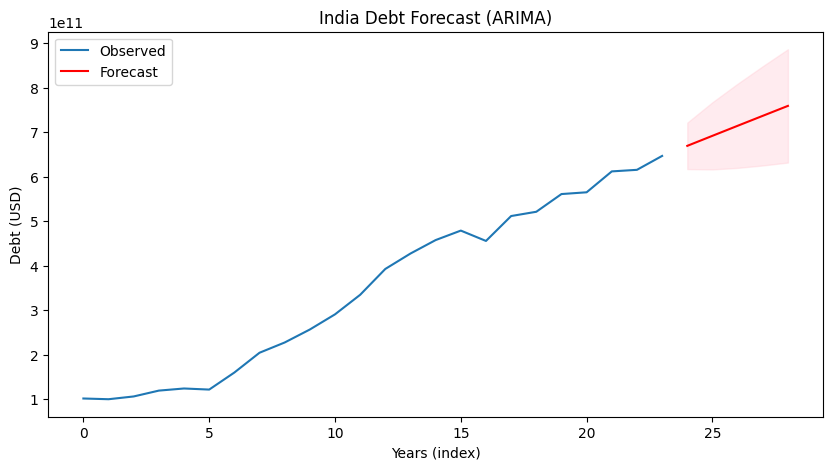

In [25]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Select country
sel_country = 'India'
series = proc_recent[proc_recent['Country'] == sel_country].set_index('Year')['Debt_USD'].dropna()

if len(series) >= 10:
    # Ensure index is numeric
    series.index = pd.RangeIndex(start=0, stop=len(series), step=1)

    # Fit ARIMA
    model_arima = ARIMA(series, order=(1,1,1))
    res = model_arima.fit()

    # Forecast 5 steps
    fc = res.get_forecast(steps=5)
    pred = fc.predicted_mean
    conf_int = fc.conf_int()

    print(res.summary())
    print("\nForecast:\n", pred)

    # Plot original + forecast
    plt.figure(figsize=(10,5))
    plt.plot(series.index, series.values, label='Observed')
    plt.plot(range(len(series), len(series)+5), pred, label='Forecast', color='red')
    plt.fill_between(range(len(series), len(series)+5),
                     conf_int.iloc[:,0],
                     conf_int.iloc[:,1],
                     color='pink', alpha=0.3)
    plt.xlabel('Years (index)')
    plt.ylabel('Debt (USD)')
    plt.title(f'{sel_country} Debt Forecast (ARIMA)')
    plt.legend()
    plt.show()
else:
    print(f"Not enough data for ARIMA for {sel_country} (years available: {len(series)})")


In [28]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.3 MB/s eta 0:00:00


## 9. Visualizations: Choropleth and Heatmap examples

Choropleth requires country codes; Plotly can map by ISO-3 codes stored in `CountryCode`.

In [29]:
# -------------------------------
# Choropleth & Heatmap Examples
# -------------------------------
import plotly.express as px
import pycountry

# Use the latest year
latest_year = proc_recent['Year'].max()
latest = proc_recent[proc_recent['Year'] == latest_year].copy()

# --- Convert ISO-2 to ISO-3 for Plotly ---
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

latest['ISO3'] = latest['CountryCode'].apply(iso2_to_iso3)
latest = latest.dropna(subset=['ISO3'])

# --- Choropleth Map ---
fig_choro = px.choropleth(
    latest,
    locations='ISO3',           # ISO-3 codes required
    color='Debt_to_GDP',        # coloring based on Debt/GDP
    hover_name='Country',
    title=f'Latest Debt-to-GDP by Country ({latest_year})',
    color_continuous_scale='Viridis',
    labels={'Debt_to_GDP':'Debt/GDP'}
)
fig_choro.update_layout(coloraxis_colorbar_title='Debt/GDP')
fig_choro.show()

# --- Heatmap of Debt-to-GDP over Years ---
# Pivot data: countries vs years
heatmap_df = proc_recent.pivot(index='Country', columns='Year', values='Debt_to_GDP')

fig_heat = px.imshow(
    heatmap_df,
    labels=dict(x="Year", y="Country", color="Debt/GDP"),
    aspect="auto",
    color_continuous_scale='Viridis',
    title="Debt-to-GDP Heatmap (Countries vs Years)"
)
fig_heat.update_xaxes(side="top")
fig_heat.show()


## 10. Save artifacts

Save models, feature CSVs, and figures as needed. The `processed_debt.csv` file is saved and will be read by the Streamlit dashboard.

In [30]:
# Save features and clustering results
features.to_csv('country_features_clusters.csv', index=False)
print("Saved country features and clusters to country_features_clusters.csv")


Saved country features and clusters to country_features_clusters.csv


In [31]:
import pycountry
import pandas as pd

# Ensure proc_recent exists
proc_recent = proc_recent.copy()

# Filter recent years
proc_recent = proc_recent[proc_recent['Year'] >= 2000].copy()

# Forward/backfill GDP if missing
proc_recent['GDP_USD'] = proc_recent.groupby('Country')['GDP_USD'].transform(lambda x: x.ffill().bfill())

# Compute Debt_to_GDP
proc_recent['Debt_to_GDP'] = proc_recent['Debt_USD'] / proc_recent['GDP_USD']

# Convert ISO-2 to ISO-3
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

proc_recent['ISO3'] = proc_recent['CountryCode'].apply(iso2_to_iso3)

# Drop rows where conversion failed or Debt_USD is NaN
tableau_df = proc_recent.dropna(subset=['ISO3','Debt_USD'])

# Export to CSV for Tableau
tableau_csv_path = "processed_debt_for_tableau.csv"
tableau_df.to_csv(tableau_csv_path, index=False)
print(f"Tableau CSV ready: {tableau_csv_path}")


Tableau CSV ready: processed_debt_for_tableau.csv
